In [2]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile

In [3]:
pasta_dados = '01'

In [4]:
dados_audio = []
for ficheiro in os.listdir(pasta_dados):
    if ficheiro.endswith('.wav'):
        caminho_completo = os.path.join(pasta_dados, ficheiro)
        partes_nome = ficheiro.replace('.wav', '').split('_')
        if len(partes_nome) == 3:
            digito = int(partes_nome[0])
            participante = partes_nome[1]
            repeticao = int(partes_nome[2])
            fs, sinal = wavfile.read(caminho_completo)
            dados_audio.append({
                'diretorio': pasta_dados,
                'nome_ficheiro': ficheiro,
                'participante': participante,
                'digito': digito,
                'repeticao': repeticao,
                'taxa_amostragem': fs,
                'sinal': sinal
            })

In [5]:
df = pd.DataFrame(dados_audio)
df = df.sort_values(by=['digito', 'repeticao']).reset_index(drop=True)
display(df.head())

,diretorio,nome_ficheiro,participante,digito,repeticao,taxa_amostragem,sinal
0,01,0_01_0.wav,01,0,0,48000,"[15, 14, 15, 15, 14, 15, 15, 14, 14, 14, 14, 1..."
1,01,0_01_1.wav,01,0,1,48000,"[2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 3, ..."
2,01,0_01_2.wav,01,0,2,48000,"[-29, -29, -29, -29, -30, -30, -30, -30, -30, ..."
3,01,0_01_3.wav,01,0,3,48000,"[3, 2, 3, 3, 3, 3, 4, 4, 3, 4, 5, 4, 3, 3, 3, ..."
4,01,0_01_4.wav,01,0,4,48000,"[25, 25, 25, 25, 24, 24, 25, 25, 25, 25, 26, 2..."


In [6]:
import matplotlib.pyplot as plt

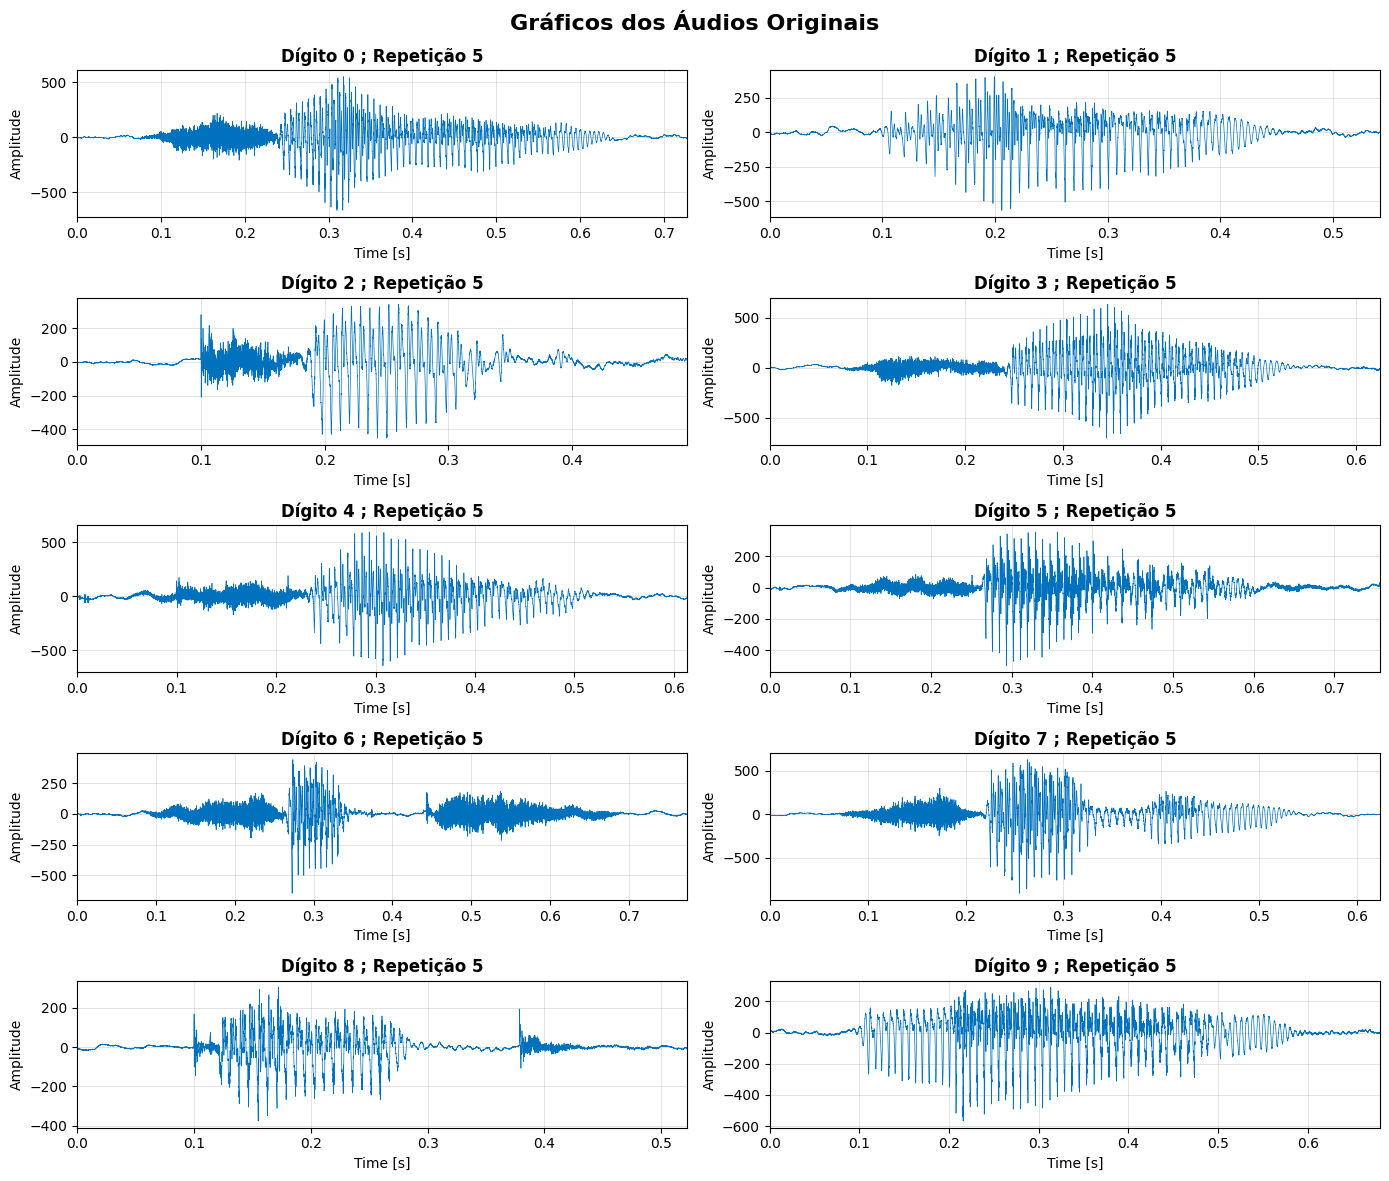

In [12]:
def plotar_sinais_audio(df_dados, coluna_sinal='sinal', titulo='Gráficos dos Áudios', repeticao=5):
    plt.style.use('default')
    df_filtrado = df_dados[df_dados['repeticao'] == repeticao].sort_values(by='digito')
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 12))
    fig.suptitle(titulo, fontsize=16, fontweight='bold')
    for i, ax in enumerate(axes.flatten()):
        if i < len(df_filtrado):
            linha = df_filtrado.iloc[i]
            sinal = linha[coluna_sinal] 
            fs = linha['taxa_amostragem']
            digito = linha['digito']
            repeticao = linha['repeticao']
            
            tempo_segundos = np.arange(len(sinal)) / fs
            
            ax.plot(tempo_segundos, sinal, color='#0072BD', linewidth=0.5) 
            ax.set_title(f'Dígito {digito} ; Repetição {repeticao}', fontsize=12, fontweight='bold')
            ax.set_xlabel('Time [s]')
            ax.set_ylabel('Amplitude')
            ax.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.5)
            ax.set_xlim([0, tempo_segundos[-1]])
            
            # Opcional: Se os sinais estiverem normalizados, pode fixar o eixo Y 
            # para evidenciar a normalização [-1, 1], comentando a linha abaixo:
            # ax.set_ylim([-1.1, 1.1]) 

    plt.tight_layout()
    fig.subplots_adjust(top=0.93)
    plt.show()

plotar_sinais_audio(df, coluna_sinal='sinal', titulo='Gráficos dos Áudios Originais')

In [8]:
def pre_processar_sinal(sinal):
    # Retirar silencio inicial
    limiar = 0.05 * np.max(np.abs(sinal))
    i_ativos = np.where(np.abs(sinal) > limiar)[0]
    
    if len(i_ativos) > 0:
        sinal_sem_silencio = sinal[i_ativos[0]:] 
    else:
        sinal_sem_silencio = sinal 
    # Normalizar
    minimo = np.min(sinal_sem_silencio)
    maximo = np.max(sinal_sem_silencio)
    sinal_normalizado = 2 * ((sinal_sem_silencio - minimo) / (maximo - minimo)) - 1
    return sinal_normalizado

In [9]:
sinais_temporarios = [pre_processar_sinal(s) for s in df['sinal']]

# Adicionar silencio no fim
tamanho_maximo = max(len(s) for s in sinais_temporarios)
sinais_finais_iguais = []
for s in sinais_temporarios:
    zeros_a_adicionar = tamanho_maximo - len(s)
    sinal_padded = np.pad(s, (0, zeros_a_adicionar), mode='constant', constant_values=0)
    sinais_finais_iguais.append(sinal_padded)
df['sinal_pre_proc'] = sinais_finais_iguais

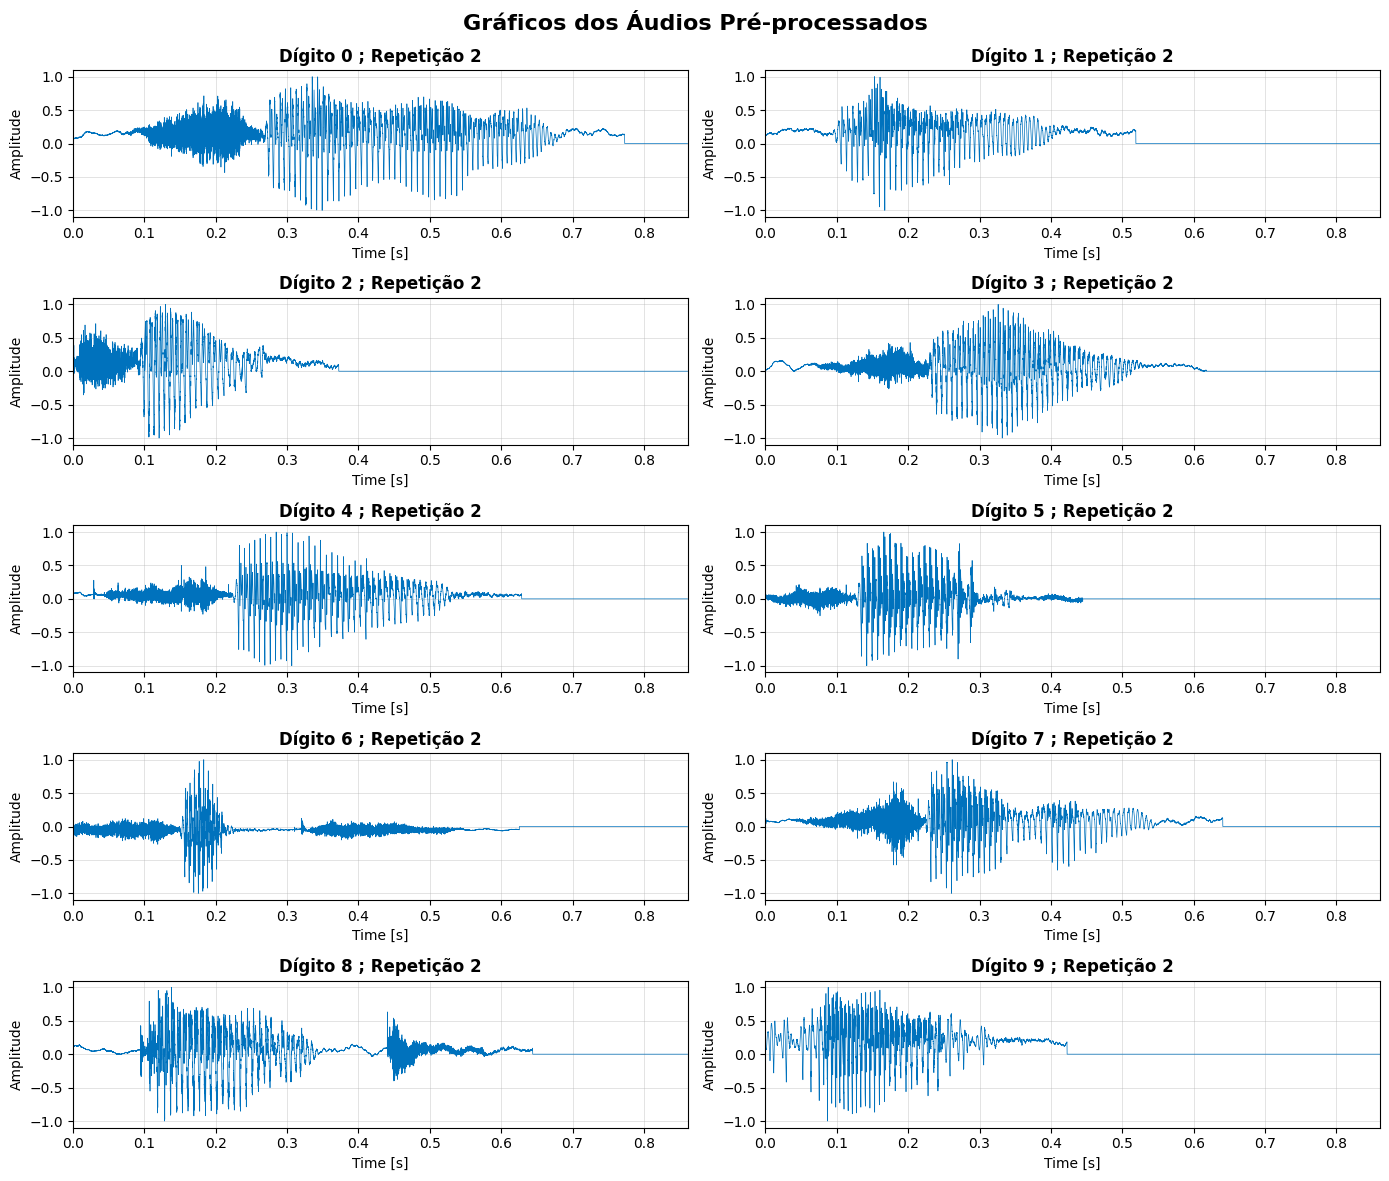

In [ ]:
plotar_sinais_audio(df, coluna_sinal='sinal_pre_proc', titulo='Gráficos dos Áudios Pré-processados',repeticao=5)

Comparando os gráficos obtidos no 3 e no 5 constatamos que o processo de pré-processamento eliminou variabilidade irrelevante, garantido o mesmo instante de início do som, a mesma escala de amplitudes, e a mesma duração.

Conseguimos ainda identificar algumas características temporais nos gráficos que poderão ser usadas para distinguir os algarismos. Por exemplo: vemos que o número seis (Six) é um pico sonoro curto, apenas uma sílaba seca. Enquanto o sete (Seven) é constituída por 2 silabas separadas por um pequeno silêncio.


In [14]:
energia_total = []
zcr = [] #Taxa de cruzamento por zero
rms = [] #Energia Efetiva
desvio_padrao = []
razao_energia = []
for sinal in df['sinal_pre_proc']:
    
    e_total = np.sum(sinal ** 2)
    energia_total.append(e_total)
    zcr.append(np.sum(np.abs(np.diff(np.sign(sinal)))) / 2)
    
    rms.append(np.sqrt(np.mean(sinal ** 2)))
    
    desvio_padrao.append(np.std(sinal))
    
    meio = len(sinal) // 2
    energia_m1 = np.sum(sinal[:meio] ** 2)
    energia_m2 = np.sum(sinal[meio:] ** 2)
    
    if energia_m2 == 0:
        razao = energia_m1  
    else:
        razao = energia_m1 / energia_m2
    razao_energia.append(razao)
df['energia_total'] = energia_total
df['zcr'] = zcr
df['rms'] = rms
df['desvio_padrao'] = desvio_padrao
df['razao_energia'] = razao_energia

print("Características temporais extraídas e guardadas com sucesso!")
display(df[['digito', 'repeticao', 'energia_total', 'zcr', 'rms', 'desvio_padrao', 'razao_energia']].head())

Características temporais extraídas e guardadas com sucesso!


,digito,repeticao,energia_total,zcr,rms,desvio_padrao,razao_energia
0,0,0,2092.963675,340.5,0.225023,0.208886,7.836538
1,0,1,2025.712929,278.5,0.221378,0.196692,8.521925
2,0,2,2877.115999,1134.5,0.263830,0.227830,1.394589
3,0,3,1269.555875,1760.5,0.175256,0.167983,1.785374
4,0,4,820.951101,1238.5,0.140930,0.138105,87.989121


C:\Users\tdami\AppData\Local\Temp\ipykernel_27288\307111954.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='digito', y=feature, data=df, ax=axes[i], palette=paleta)
C:\Users\tdami\AppData\Local\Temp\ipykernel_27288\307111954.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='digito', y=feature, data=df, ax=axes[i], palette=paleta)
C:\Users\tdami\AppData\Local\Temp\ipykernel_27288\307111954.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='digito', y=feature, data=df, ax=axes[i], palette=paleta)
C:\Users\tdami\AppData\Local

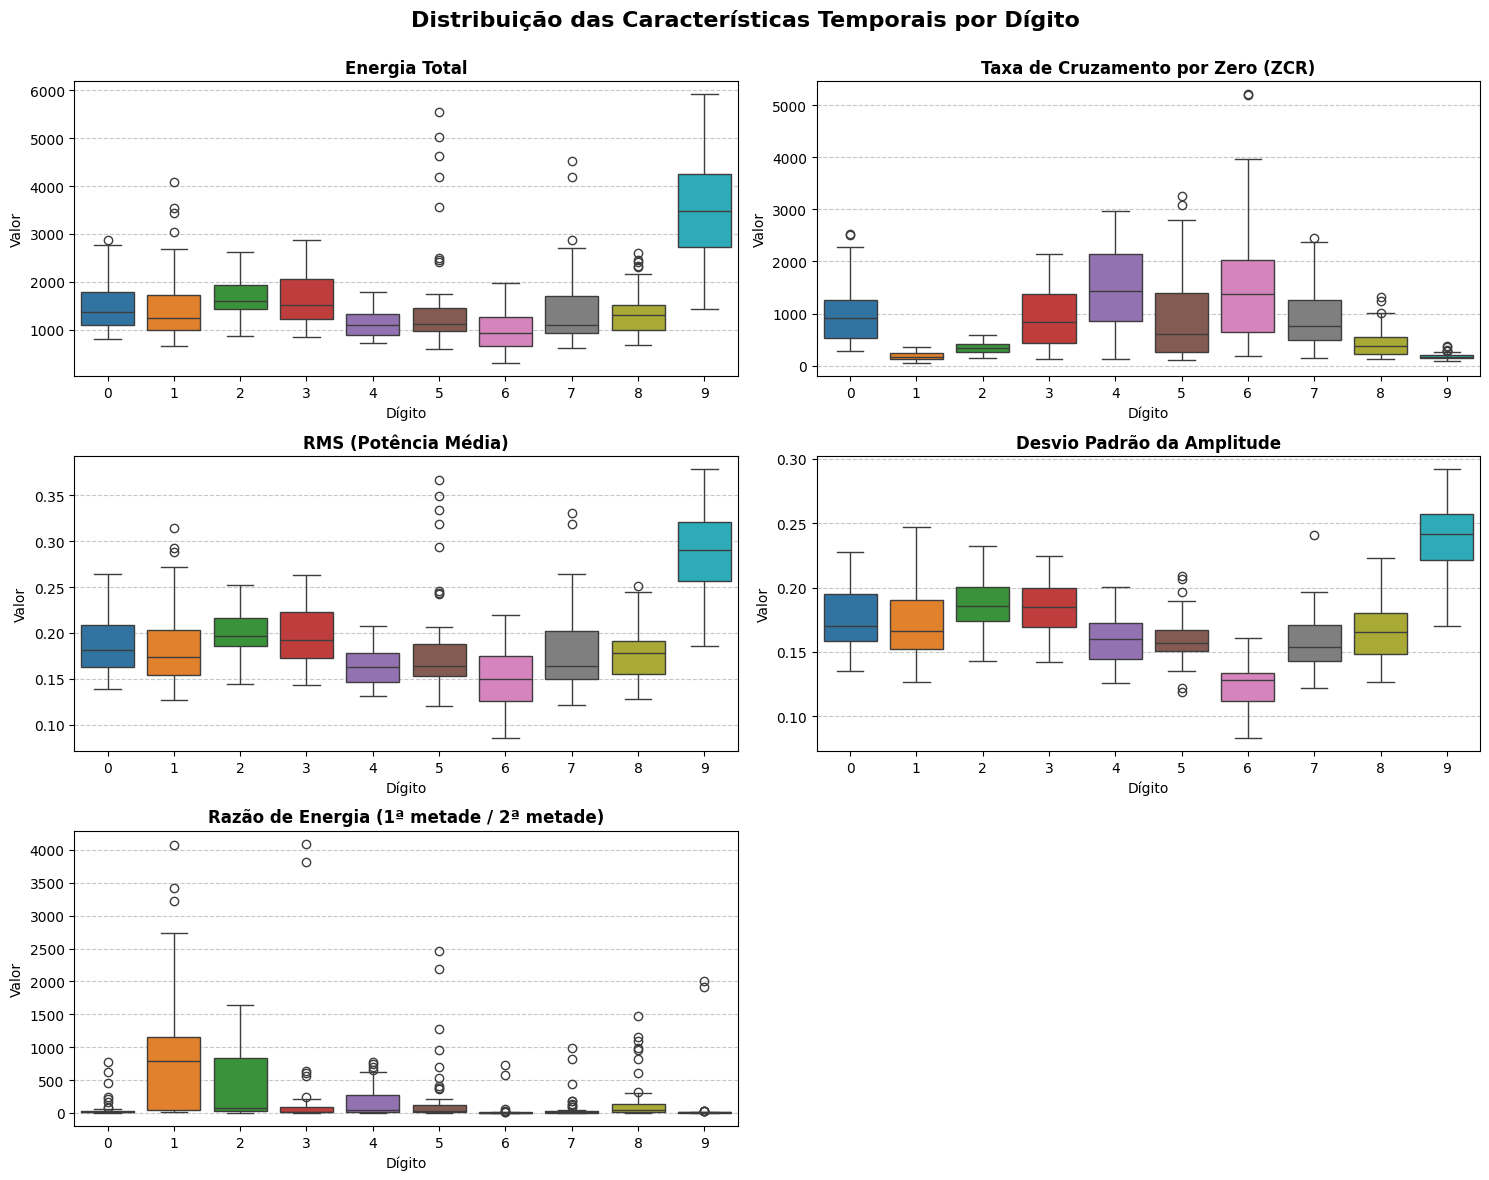

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir a paleta de cores para os 10 dígitos
paleta = sns.color_palette("tab10", 10)

# Lista das 5 características temporais que calculámos no Passo 7
features = ['energia_total', 'zcr', 'rms', 'desvio_padrao', 'razao_energia']
nomes_features = ['Energia Total', 'Taxa de Cruzamento por Zero (ZCR)', 
                  'RMS (Potência Média)', 'Desvio Padrão da Amplitude', 
                  'Razão de Energia (1ª metade / 2ª metade)']

# --- 1. Criar a grelha de Boxplots para avaliar individualmente cada feature ---
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Distribuição das Características Temporais por Dígito', fontsize=16, fontweight='bold')

# Achatar a matriz de eixos para facilitar o loop
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='digito', y=feature, data=df, ax=axes[i], palette=paleta)
    axes[i].set_title(nomes_features[i], fontweight='bold')
    axes[i].set_xlabel('Dígito')
    axes[i].set_ylabel('Valor')
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# Ocultar o último gráfico (vazio) pois temos 5 features para 6 espaços
axes[5].set_visible(False)
plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

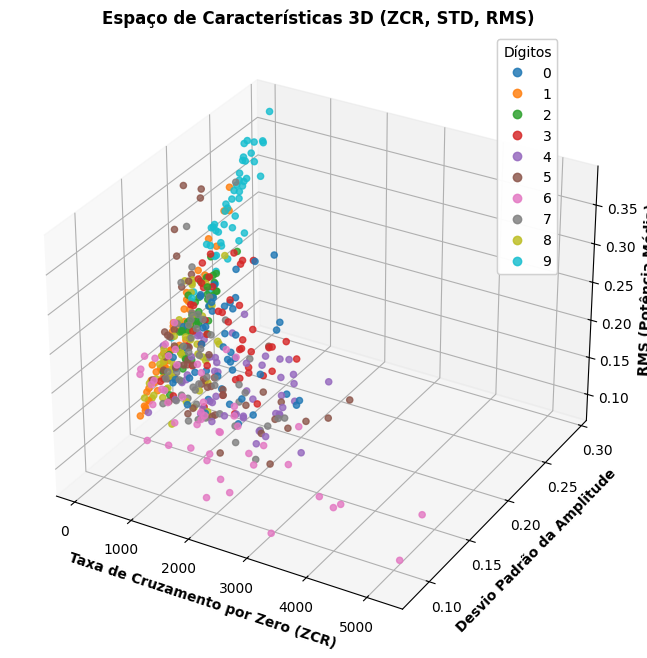

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = df['zcr']
y = df['desvio_padrao']
z = df['rms']

scatter = ax.scatter(x, y, z, c=df['digito'], cmap='tab10', s=20, alpha=0.8)
ax.set_xlabel('Taxa de Cruzamento por Zero (ZCR)', fontweight='bold')
ax.set_ylabel('Desvio Padrão da Amplitude', fontweight='bold')
ax.set_zlabel('RMS (Potência Média)', fontweight='bold')
ax.set_title('Espaço de Características 3D (ZCR, STD, RMS)', fontweight='bold')

legend = ax.legend(*scatter.legend_elements(), title="Dígitos", bbox_to_anchor=(0.9, 1))
ax.add_artist(legend)

plt.show()